In [3]:
# add autoreload
%load_ext autoreload
%autoreload 2
import os
import sys
import json

import numpy as np
import pandas as pd
import scipy as sc

from collections import defaultdict
import re
import deduce

from tqdm import tqdm
import seaborn as sns

from gensim.models import phrases

import matplotlib.pyplot as plt

import dill

# Context:
* $100$ K echocardiographic reports available. 
* we want to extract diagnoses regarding the left-ventricle function
* we have $5000$ reports with labeled spans.

# Goal:
Train a "model" that can
1. identify the spans
2. classify the spans

# Approach: MedCAT - MetaCAT

## Two-step approach

* unsupervised training on the documents
* add a single custom entity with a custom identifier
* train a model to identify the custom entities
* supervised training on the meta-annotations of the entities

## One-step approach

* unsupervised training on the documents
* add custom entities based on the spans and their labels
* train a model to identify the custom entities

# Approach: biLSTM/transformer

## Two-step approach

* Train a model to identify the spans: self-supervision by random selecting non-span ranges as negative examples
* Train a model to classify the spans: supervised based on the labeled spans 
* Combine the model in one pipeline

## One-step approach
* Assign a label to each span
* Train a model to identify the spans

In [4]:
# TODO:..
# 1. add negatives:
#    * either by directly injecting in the training set
#    * or by altering the MetaCAT training routine
#    * (preferred) or by adding a "no_label" class to each label
# 2. re-train with reduced labels
# 3. re-evaluate with whole pipeline!

##  Load Medcat modelpack

In [5]:
# load dotenv
from dotenv import load_dotenv
load_dotenv('../.env')
# extract the environment variable 'medcat_pack'


True

In [6]:
from medcat.cat import CAT
from medcat.vocab import Vocab
from medcat.cdb import CDB
from medcat.config import Config
from medcat.meta_cat import MetaCAT

d:\VENVS\Envs\nlp_310\lib\site-packages\medcat\cat.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [7]:
base_medcat_path = os.getenv('medcat_pack')
pack_location = 'umls-dutch-v1-10_echo'
prep_medcat = False
train_with_negatives = True
REDUCED=True

# Load texts

In [8]:
echo_path = 'T://lab_research/RES-Folder-UPOD/Echo_label/E_ResearchData/2_ResearchData'
# load the jsonl in a dataframe
texts = pd.read_json(os.path.join(echo_path, 'outdb_140423.jsonl'), lines=True)
#texts_zipped = zip(texts['text'], texts['_input_hash'], texts['_task_hash'])

# Load train/test splits

In [9]:
train_indcs = pd.read_csv(os.path.join(echo_path, 'train_echoid.csv'), sep=',')
test_indcs = pd.read_csv(os.path.join(echo_path, 'test_echoid.csv'), sep=',')

train_indcs = train_indcs[train_indcs.input_hash.notna()]
test_indcs = test_indcs[test_indcs.input_hash.notna()]

In [10]:
TRAIN_INPUT_HASH = set(train_indcs['input_hash'].astype(int).to_list())
TRAIN_TASK_HASH = set(train_indcs['task_hash'].astype(int).to_list())

TEST_INPUT_HASH = set(test_indcs['input_hash'].astype(int).to_list())
TEST_TASK_HASH = set(test_indcs['task_hash'].astype(int).to_list())

In [11]:
texts_train = texts.loc[texts._input_hash.isin(TRAIN_INPUT_HASH)]
texts_test = texts.loc[texts._input_hash.isin(TEST_INPUT_HASH)]

## Make splitted data

* MedCAT train files
* class-dictionary with dataframes

In [12]:
def get_medcat_json(filename: str=None, HashSet: set=False, ClassName: str=None):
    # to add negatives: we need to know, per span, if it is not labeled per class
    # if it is labeled for a class, and not for others, then it gets a 'nolabel' value
    texts = pd.read_json(filename, lines=True)
    output = {"projects": [{
                "name": ClassName,
                "id": 42,
                "cuis": "",
                "tuis": "",
                "documents": None
            }]}
    
    documents = []
    for i, _row in enumerate(texts.iterrows()):
        row = _row[1]
        if (row["_input_hash"] in HashSet) | (HashSet is False):
            txt = row['text']
            id = i
            input_hash = row["_input_hash"]
            task_hash = row["_task_hash"]
            annotations = []
            for j, ann in enumerate(row["spans"]):
                res = {}
                res['user'] = 'BVE'
                res['cui'] = 123
                res['id'] = j
                res['start'] = ann['start']
                res['end'] = ann['end']
                res['value'] = txt[ann['start']:ann['end']]
                res['validated'] = True
                res['correct'] = True
                res['deleted'] = False
                res['alternative'] = False
                res['killed'] = False
                res["meta_anns"] = {
                    ClassName: {
                        "name": ClassName,
                        "validated": True,
                        "accuracy": 1.0,
                        "value": ann['label']
                    }
                }                
                annotations.append(res)
            doc = {
                'id': id,
                'text': txt,
                'input_hash': input_hash,
                'task_hash': task_hash,
                'annotations': annotations         
            }
            documents.append(doc)
    output['projects'][0]['documents'] = documents
    
    return output


In [13]:
if REDUCED==True:
    file_dir = os.path.join(echo_path, 'echo_span_labels', 'reduced_labels')
    class_names = os.listdir(file_dir)
else:
    file_dir = os.path.join(echo_path, 'echo_span_labels', 'full_labels')
    class_names = os.listdir(file_dir)
    
    
merged_index = [i for i,t in enumerate(class_names) 
                    if ('merged' in t) | ('old' in t)]
merged_index = sorted(merged_index, reverse=True)

for mind in merged_index:
    class_names.pop(mind)
class_ds = defaultdict(dict)

for file_name in class_names:   
    _class = file_name.split(".")[0]
    fn = os.path.join(file_dir, file_name)
    class_ds[_class]['ds'] = pd.read_json(fn, lines=True)
    
    class_ds[_class]['train'] = {}
    class_ds[_class]['test'] = {}    
    
    #TODO: has to be refactored
    medcat_json = get_medcat_json(fn, TRAIN_INPUT_HASH, _class)
    medcat_out = os.path.join(echo_path, 'medcat_labels', 'train', f'medcat_{_class}.json')
    json.dump(medcat_json, open(medcat_out, 'w'))
    class_ds[_class]['train']['location'] = medcat_out
    class_ds[_class]['train']['json'] = medcat_json
    
    medcat_json = get_medcat_json(fn, TEST_INPUT_HASH, _class)
    medcat_out = os.path.join(echo_path, 'medcat_labels', 'test', f'medcat_{_class}.json')
    json.dump(medcat_json, open(medcat_out, 'w'))
    class_ds[_class]['test']['location'] = medcat_out
    class_ds[_class]['test']['json'] = medcat_json
    
    class_ds[_class]['labels'] = set([span_dict['label'] 
                                        for span_list in class_ds[_class]['ds']['spans'].tolist()
                                        for span_dict in span_list])
    
ClassMap = defaultdict(dict)
for k, v in class_ds.items():
    for lab in v['labels']:
        ClassMap[lab] = k
ClassMap['normal'] = 'normal'

## Unsupervised learning for NER+L

In [ ]:
MCAT = CAT.load_model_pack(os.path.join(base_medcat_path, pack_location))

MCAT.train(texts_train.text.values, 
            nepochs=3, 
            progress_print=10,  
            is_resumed=True)
MCAT.create_model_pack(base_medcat_path + "/umls-dutch-v1-10_echo")

### Add label spans from Prodigy annotations

In [ ]:
span_sets = defaultdict(set)
for _class, dsd in tqdm(class_ds.items()):
        ds = dsd['ds']
        span_set = set()
        span_list = []
        ds = ds[ds._input_hash.isin(TRAIN_INPUT_HASH)]
        for k, (_spans, text) in enumerate(zip(ds[ds.spans.notna()].spans.values,
                                            ds[ds.spans.notna()].text.values)):
            for _span in _spans:
                start, end = _span['start'], _span['end']
                span_set.add(text[start:end])
                span_list.append(text[start:end])
        span_sets[_class] = span_set

In [ ]:
# TODO: interesting to add variants without the abbreviations?
# TODO: including paraphrasing?

In [ ]:
for _class, span_set in tqdm(span_sets.items()):
    for _span in span_set:
        MCAT.add_and_train_concept(cui=_class,
                                name=_span, 
                                do_add_concept=True,
                                negative=False,
                            )

## Supervised learning for NER+L

In [ ]:
MCAT.train_supervised(data_path=os.path.join(base_medcat_path, 
                                 "umls-dutch-v1-10_echo",
                                 "input/ner_l_anno/trainer_export.json"), 
                      nepochs=4,
                      print_stats=0,
                      use_filters=False)
medcat_path = base_medcat_path + "/umls-dutch-v1-10_echoV2"
MCAT.create_model_pack(medcat_path)

## Supervised learning of MetaCAT models

In [15]:
# load MCAT from file
medcat_path = os.path.join(base_medcat_path, 'umls-dutch-v1-10_echoV2')

In [ ]:
MCAT = CAT.load_model_pack(medcat_path)

In [ ]:
from medcat.meta_cat import MetaCAT
from medcat.config_meta_cat import ConfigMetaCAT
from medcat.tokenizers.meta_cat_tokenizers import TokenizerWrapperBPE, ByteLevelBPETokenizer

In [ ]:
# load tokenizer from negation_model
# tokenizer folder 
tok_folder = 'T:/laupodteam/AIOS/Bram/language_modeling/Clinical_embeddings/bigrams/with_tokenizer/v2/tokenizer'
emb_folder = 'T:/laupodteam/AIOS/Bram/language_modeling/Clinical_embeddings/bigrams/with_tokenizer/v2/SG'
tokenizer = ByteLevelBPETokenizer.from_file(os.path.join(tok_folder, 'vocab.json'), 
                                            os.path.join(tok_folder, 'merges.txt'))
wrapped_tokenizer = TokenizerWrapperBPE(hf_tokenizers=tokenizer)
wrapped_tokenizer.save(medcat_path + "/assets/tokenizer")

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
vec_path = os.path.join(emb_folder, 'sg')
print(vec_path)
w2v = KeyedVectors.load(vec_path)

In [ ]:
# Create embedding matrix
embeddings = []
words_not_present = []

for i in range(tokenizer.get_vocab_size()):
    word = tokenizer.id_to_token(i)
    if word in w2v:
        embeddings.append(w2v[word])
    else:
        words_not_present.append(i)
        embeddings.append(np.random.random(300))
        
mean_vector = np.mean(embeddings, axis=0)

for i in words_not_present:
    embeddings[i] = mean_vector

# Save the embeddings
embeddings_array = np.array(embeddings)
np.save(open(medcat_path+"/assets/embeddings/embedding.npy", 
             'wb'), embeddings_array)

print(f"Words not present:{len(words_not_present)}")

In [ ]:
for _class, d in class_ds.items():
    if _class != 'normal':
        print(f"Commencing training of biLSTM-span for {_class}...")
        config_metacat = ConfigMetaCAT()
        config_metacat.general['category_name'] = _class
        config_metacat.train['nepochs'] = 25
        config_metacat.train['score_average'] = 'weighted'
        config_metacat.model['hidden_size'] = 256
        config_metacat.model['input_size'] = 300
        config_metacat.model['dropout'] = 0.3
        config_metacat.model['num_layers'] = 3
        config_metacat.model['num_directions'] = 2
        config_metacat.model['nclasses'] = len(d['labels'])
        config_metacat.model['model_name'] = 'lstm'
        
        meta_cat = MetaCAT(tokenizer=wrapped_tokenizer,
                    embeddings=embeddings_array, 
                    config=config_metacat)
        
        train_path = d['train']['location']
        model_path = os.path.join(medcat_path, f"meta_{_class}")
        os.makedirs(model_path, exist_ok=True)
        
        meta_cat.train(json_path=train_path, 
                        save_dir_path=model_path)
        
        meta_cat.save(save_dir_path=model_path)
        # now manually add the model to the model_pack...
        label_dict = config_metacat.general.category_value2id
        
        # add to config
        medcat_config = json.load(open(os.path.join(medcat_path, 'model_card.json'), 'r'))
        
        # add to "MetaCAT models" list
        medcat_config["MetaCAT models"].append({
                      "Category Name": _class,
                      "Description": f"Labels: {REDUCED}, Negatives: {train_with_negatives}",
                      "Classes": label_dict,
                        "Model": "lstm"
                    })
        # write config to .json
        json.dump(medcat_config, open(os.path.join(medcat_path, 'model_card.json'), 'w'))

## Load  new model pack

In [16]:
medcat_path

'D://LanguageModels/MEDCAT/ModelPacks/UMCU_v1\\umls-dutch-v1-10_echoV2'

In [19]:
MCATnew = CAT.load_model_pack(os.path.join(medcat_path))

d:\VENVS\Envs\nlp_310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'nl_core_news_lg' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Apply to texts

In [20]:
from spacy import displacy

In [21]:
i = 123
doc = MCATnew(texts.text.values[i])
displacy.render(doc, style='ent')

In [22]:
def create_dict_with_conf(ent):
    result_dict = {}
    for k, v in ent._.meta_anns.items():
        result_dict[k] = v['value']
        result_dict[f'conf_{k}'] = v['confidence']
    return result_dict

In [ ]:
doc = MCATnew(texts.text.values[i])
inds = []
res = []
for ent in doc.ents:
    inds.append(ent.text)
    res.append(create_dict_with_conf(ent))
    
res_df = pd.DataFrame(res, index=inds)

In [ ]:
res_df.c

In [33]:
set([v for v in ClassMap.values()])

{'aortic_regurgitation',
 'aortic_stenosis',
 'diastolic_dysfunction',
 'lv_dil',
 'lv_syst_func',
 'mitral_regurgitation',
 'normal',
 'pe',
 'rv_dil',
 'rv_syst_func'}

In [45]:
# lv_syst_func: 
# lv_syst_func_normal and lv_sys_func_normal?
# lv_sys_func_unchanged,  lv_sys_func_unknown and lv_sys_func_improved?

# rv_syst_func:
# rv_syst_func_normal and rv_sys_func_normal

# pe_not_present:
# pe_not_present? 
# pe?



['pe_severe', 'pe_moderate', 'pe_mild', 'pe_not_present', 'pe']

## Evaluate

In [52]:
TEST_RESULTS = {}
for k in class_ds.keys():
    if k != 'normal':
        CATmodel = MetaCAT.load(os.path.join(medcat_path, f'meta_{k}'))
        CATmodel.config['train']['score_average'] = 'macro' # weighted, macro
        test_location = class_ds[k]['test']['location']
        test_labels = json.load(open(test_location, 'r'))
        bulk_res = CATmodel.eval(test_location)
        
        res_count = defaultdict(int)
        for doc in test_labels['projects'][0]['documents']:
            anns = doc['annotations']
            if len(anns)>0:
                for ann in anns:            
                    _ann = ann['meta_anns'][k]
                    res_count[_ann['value']] += 1

        TEST_RESULTS[k] = {
            'f1':  bulk_res['f1'],
            'precision': bulk_res['precision'],
            'recall': bulk_res['recall'],
            'confusion_df': bulk_res['confusion matrix'],
            'real_presence': res_count
        }

In [46]:
print(TEST_RESULTS.keys())

dict_keys(['aortic_regurgitation', 'aortic_stenosis', 'diastolic_dysfunction', 'lv_dil', 'lv_syst_func', 'mitral_regurgitation', 'pe', 'rv_dil', 'rv_syst_func'])


In [ ]:
dill.dump(TEST_RESULTS, file=open("../artifacts/MetaCAT_test_results_reduced.pkl", "wb"))
#TEST_RESULTS = dill.load(open("../artifacts/MetaCAT_test_results.pkl", "rb"))

## Assessment of performance in the wild

In [23]:
merged_labels_train = get_medcat_json(open(os.path.join(file_dir, 'merged_labels.jsonl'), 'r'), 
                                    TRAIN_INPUT_HASH, 'merged')['projects'][0]['documents']

merged_labels_test = get_medcat_json(open(os.path.join(file_dir, 'merged_labels.jsonl'), 'r'), 
                                    TEST_INPUT_HASH, 'merged')['projects'][0]['documents']

In [24]:
comparison_list = []
for medcat_doc in tqdm(merged_labels_test):
    txt = medcat_doc['text']
    parsed_doc = MCATnew(txt)

    res = []
    start_stop = []
    for ent in parsed_doc.ents:
        start_stop.append((ent.start_char, ent.end_char))
        res.append(create_dict_with_conf(ent))
    
    medcat_doc['predicted'] = {k:v for k,v in zip(start_stop, res)}
    comparison_list.append(medcat_doc)
comparison_list_with_annotations_present = [d for d in comparison_list if len(d['annotations'])>0]

100%|██████████| 991/991 [03:33<00:00,  4.63it/s]


In [25]:
comparison_list_with_annotations_present[0]

{'id': 5,
 'text': 'Forse LVEDd. Goede LV en RV functie. Geen belangrijke klepafwijkingen.',
 'input_hash': -1055899436,
 'task_hash': -1034767905,
 'annotations': [{'user': 'BVE',
   'cui': 123,
   'id': 0,
   'start': 37,
   'end': 69,
   'value': 'Geen belangrijke klepafwijkingen',
   'validated': True,
   'correct': True,
   'deleted': False,
   'alternative': False,
   'killed': False,
   'meta_anns': {'merged': {'name': 'merged',
     'validated': True,
     'accuracy': 1.0,
     'value': 'tricuspid_valve_native_regurgitation_not_present'}}},
  {'user': 'BVE',
   'cui': 123,
   'id': 1,
   'start': 13,
   'end': 35,
   'value': 'Goede LV en RV functie',
   'validated': True,
   'correct': True,
   'deleted': False,
   'alternative': False,
   'killed': False,
   'meta_anns': {'merged': {'name': 'merged',
     'validated': True,
     'accuracy': 1.0,
     'value': 'rv_sys_func_normal'}}},
  {'user': 'BVE',
   'cui': 123,
   'id': 2,
   'start': 13,
   'end': 35,
   'value': 'Goede

In [26]:
def get_pred_list(pred_dict: dict=None):
    return [v for k,v in pred_dict.items() if 'conf_' not in k]
    
span_suggester_comparison_list = []
for d in tqdm(comparison_list_with_annotations_present):
    anns = d['annotations']
    span_cat_list = []
    for ann in anns:
        span = (ann['start'], ann['end'])
        class_val = ann['meta_anns']['merged']['value']
        span_cat_list.append((span, class_val))
    
    pred_list = []
    for k, pred in d['predicted'].items():
        pred_list.append((k, get_pred_list(pred)))
    
    span_suggester_comparison_list.append([span_cat_list, pred_list])

100%|██████████| 952/952 [00:00<00:00, 47603.45it/s]


In [27]:
# We want to get the coverage of spans -> a count of all (partially) overlapping spans
# We want to get the token overlap of covered spans (Jaccard?)
# span overlap count

def _tuple_overlap(tL, tR):
    # tL: tuple(begin, end)
    # tR: tuple(begin, end)
    tLrange = set(range(*tL))
    tRrange = set(range(*tR))
               
    InterSection = len(tLrange.intersection(tRrange))
    Union = len(tLrange.union(tRrange))
    
    return InterSection/Union if Union>0 else np.nan

def span_overlap_counter(labeled_spans, reversed=False):
    # label_spans: list[[list[((begin,end), label)], list[((begin,end), [labels])]]]
    OverlapList = []
    for span_labs in labeled_spans:
        span_set_medcat = set()
        span_set_labeled = set()
        for lab_span in span_labs[0]:
            span_set_labeled.add(lab_span[0])
        
        for med_span in span_labs[1]:
            span_set_medcat.add(med_span[0])
        
        # check overlap
        jaccard_indices = []
        if reversed:
            left_spans = span_set_medcat
            right_spans = span_set_labeled          
        else:
            left_spans = span_set_labeled
            right_spans = span_set_medcat
        
        for spanL in left_spans:
            _jaccard_indices = []            
            for spanR in right_spans:
                _jaccard_indices.append(_tuple_overlap(spanL, spanR))
            try:
                max_ = max(_jaccard_indices)
            except:
                max_ = np.nan
            jaccard_indices.append(max_)
        OverlapList.append(jaccard_indices)
    return OverlapList

def span_overlap_counter_with_assignment(labeled_spans):
    # label_spans: list[[list[((begin,end), label)], list[((begin,end), [labels])]]]
    OverlapList = []
    for span_labs in labeled_spans:
        span_set_medcat = set()
        span_dict_labeled = defaultdict(set)
        for lab_span in span_labs[0]:
            span_dict_labeled[lab_span[1]].add(lab_span[0])
        
        for med_span in span_labs[1]:
            span_set_medcat.add(med_span[0])
        
        # check overlap
        jaccard_indices = defaultdict(list)
        for spanClass, spanLabs in span_dict_labeled.items():
            for spanLab in spanLabs:                         
                _jaccard_indices = []   
                for spanMedcat in span_set_medcat:
                    _jaccard_indices.append(_tuple_overlap(spanLab, spanMedcat))
                try:
                    max_ = max(_jaccard_indices)
                except:
                    max_ = np.nan
                jaccard_indices[spanClass].append(max_)
        OverlapList.append(jaccard_indices)
    return OverlapList
    

In [44]:
docDict

defaultdict(<function __main__.<lambda>()>,
            {'rv_syst_func': defaultdict(int, {'rv_sys_func_normal': 0})})

In [64]:
span_suggester_comparison_list[0][0][0]

((37, 69), 'tricuspid_valve_native_regurgitation_not_present')

In [75]:
# end-to-end performance, requires an implicit "no label" label for consistency
# assuming one-versus-all for scoring
# tp: present and pos pred & pos lab
# tn: present and neg pred & neg lab (i.e. not a particular class value)
# fp: present and pos pred & neg lab (i.e. not a particular class value)
# fn: present and neg pred & neg lab 
# The only difference with the exact matching is that we add a negative label called "no label"

'''
ConfusionDict = {'Class': {
    'ClassValue1': {
        'fp': 
        'fn': 
        'tp': 
        'tn': 
    } 
}}
'''
# from true -> predicted 
##########################
min_jacc = 0.5 # This is somewhat arbitrary: caveat it is :)
totList = []
for comp in span_suggester_comparison_list:
    docDict = defaultdict(lambda: defaultdict(lambda : defaultdict(int)))
    conc_true_list = defaultdict(list)
    for (tTrue_l, tTrue_r), True_class_value in comp[0]:
        conc_true_list[(tTrue_l, tTrue_r)].append(True_class_value)
        
    for tTrue, True_labs in conc_true_list.items():
        # check if there is an overlapping span (with some minimum Jaccard)
        _classes = [ClassMap.get(True_lab) for True_lab in True_labs] 
        for i, _c in enumerate(_classes):
            found = False
            if (_c is not None) & (isinstance(_c, str)):        
                for tPred, Pred_labs in comp[1]:
                    if _tuple_overlap(tTrue, tPred)>min_jacc:                        
                        if True_labs[i] in Pred_labs:
                            docDict[_c][True_labs[i]]['tp'] += 1
                            # fp for all other class values in Pred_labs?
                            for pred_lab in Pred_labs:
                               if pred_lab not in True_labs:
                                   __c = ClassMap.get(pred_lab)
                                   if (__c is not None) & (isinstance(__c, str)):
                                       docDict[__c][pred_lab]['fp'] += 1 
                            found = True
                        else:
                            docDict[_c][True_class_value]['fn'] += 1
                if not found:
                    docDict[_c][True_class_value]['fn'] += 1

    totList.append(docDict)
    
# collect per class per class value the amount of tp, fp, fn
finalDict = defaultdict(lambda: defaultdict(lambda : defaultdict(int)))
for d in totList:
    for k,v in d.items():
        for _k, _v in v.items():
            for __k, __v in _v.items():
                finalDict[k][_k][__k] += __v

In [88]:
# given the tp, fp, fn the precision, recall, f1 can be calculated
eps = 1e-7
precision = lambda tp,fp: tp/(tp+fp+eps)
recall = lambda tp,fn: tp/(tp+fn+eps)
f1 = lambda p,r: 2*p*r/(p+r+eps)

In [91]:
scoreDict = defaultdict(lambda: defaultdict(lambda : defaultdict(int)))
for k,v in finalDict.items():
    for _k, _v in v.items():
        fp = _v['fp'] if not isinstance(_v['fp'], dict) else 0
        fn = _v['fn'] if not isinstance(_v['fn'], dict) else 0
        tp = _v['tp'] if not isinstance(_v['tp'], dict) else 0
        totCount = fp + fn + tp        
        prec = precision(tp,fp)
        rec = recall(tp,fn)
        scoreDict[k][_k]['count'] = totCount
        scoreDict[k][_k]['precision'] = prec
        scoreDict[k][_k]['recall'] = rec
        scoreDict[k][_k]['f1'] = f1(prec,rec)

In [96]:
classScores = defaultdict(lambda: defaultdict(float))
for k,v in scoreDict.items():
    totCount = 0
    precF = 0
    recF = 0
    f1F = 0
    for _k, _v in v.items():
        totCount += _v['count']
        precF += _v['precision']*_v['count']
        recF += _v['recall']*_v['count']
        f1F += _v['f1']*_v['count']
    classScores[k]['precision'] = precF/totCount
    classScores[k]['recall'] = recF/totCount
    classScores[k]['f1'] = f1F/totCount

In [97]:
classScores

defaultdict(<function __main__.<lambda>()>,
            {'aortic_regurgitation': defaultdict(float,
                         {'precision': 0.1010059750466348,
                          'recall': 0.8430611588916136,
                          'f1': 0.17743579602299414}),
             'aortic_stenosis': defaultdict(float,
                         {'precision': 0.07198789396666393,
                          'recall': 0.4592650659665236,
                          'f1': 0.12438773964699062}),
             'diastolic_dysfunction': defaultdict(float,
                         {'precision': 0.08899676371946863,
                          'recall': 0.9607605159354639,
                          'f1': 0.15192714775391253}),
             'lv_dil': defaultdict(float,
                         {'precision': 0.0833650551343154,
                          'recall': 0.9044537480867266,
                          'f1': 0.14966438021288783}),
             'lv_syst_func': defaultdict(float,
                    

In [85]:
OverlapJaccardIndices = span_overlap_counter(span_suggester_comparison_list, reversed=False)
OverlapJaccardIndicesReversed = span_overlap_counter(span_suggester_comparison_list, reversed=True)
OverlapJaccardClassIndices = span_overlap_counter_with_assignment(span_suggester_comparison_list)

In [73]:
PerClassValueJaccard = defaultdict(list)
for d in OverlapJaccardClassIndices:
    for k,v in d.items():
        PerClassValueJaccard[k].extend(v)

In [81]:
PerClassJaccard = defaultdict(list)
failed_cvs = set()
for cv, v in PerClassValueJaccard.items():
    try:
        PerClassJaccard[ClassMap[cv]].extend(v)
    except:
        failed_cvs.add(cv)

Mean document coverage: nan, with 0.6787009164851803 over all tokens


C:\Users\bes3\AppData\Local\Temp\ipykernel_25464\3323372547.py:1: RuntimeWarning: Mean of empty slice
  MeanPerDocument = [np.nanmean(v) for v in OverlapJaccardIndices]
C:\Users\bes3\AppData\Local\Temp\ipykernel_25464\3323372547.py:4: RuntimeWarning: Mean of empty slice
  MeanPerDocumentRev = [np.nanmean(v) for v in OverlapJaccardIndicesReversed]


Text(0.5, 1.0, 'Span overlap per document')

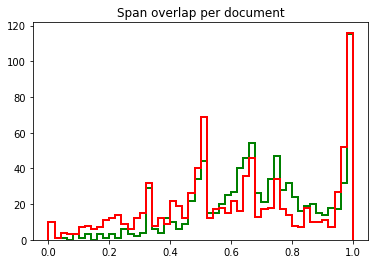

In [88]:
MeanPerDocument = [np.nanmean(v) for v in OverlapJaccardIndices]
MeanOverall = np.nanmean([_v for v in OverlapJaccardIndices for _v in v])

MeanPerDocumentRev = [np.nanmean(v) for v in OverlapJaccardIndicesReversed]
MeanOverallRev = np.nanmean([_v for v in OverlapJaccardIndicesReversed for _v in v])


print(f"Mean document coverage: {np.mean(MeanPerDocument)}, with {MeanOverall} over all tokens")

plt.hist(MeanPerDocument, bins=50, color='green', histtype='step', lw=2);
plt.hist(MeanPerDocumentRev, bins=50, color='red', histtype='step', lw=2);

plt.title("Span overlap per document")

In [89]:
[{'class': k, 'mean': np.nanmean(v)} for k,v in PerClassJaccard.items()]

[{'class': 'rv_syst_func', 'mean': 0.7545531942049616},
 {'class': 'lv_syst_func', 'mean': 0.7214597347756085},
 {'class': 'aortic_regurgitation', 'mean': 0.5634756585386702},
 {'class': 'mitral_regurgitation', 'mean': 0.6458413279230175},
 {'class': 'aortic_stenosis', 'mean': 0.4833450543268532},
 {'class': 'lv_dil', 'mean': 0.46552535384586846},
 {'class': 'rv_dil', 'mean': 0.320169994753083},
 {'class': 'diastolic_dysfunction', 'mean': 0.7830192157449651},
 {'class': 'pe', 'mean': 0.7546764486132639}]

In [ ]:
MinMean = 0.25
CheckRes = [{'Jaccard': v, 
             'res': comparison_list_with_annotations_present[i]} 
            for i,v in enumerate(OverlapJaccardIndices)
            if (np.mean(v)<MinMean) | (np.isnan(np.mean(v)))]

In [ ]:
print(f"We have {len(CheckRes)} documents to check")

In [ ]:
CheckRes[0]['res']['predicted']

In [ ]:
# TODO: check maximum length of the spans detected with MedCAT.